# INFO 5613 – Class 17: Network growth

[Brian C. Keegan, Ph.D.](http://brianckeegan.com/)  
[Assistant Professor, Department of Information Science](https://www.colorado.edu/cmci/people/information-science/brian-c-keegan)  
University of Colorado Boulder  

Copyright and distributed under an [MIT License](https://opensource.org/licenses/MIT)

## Import libraries

In [572]:
# Load networkx for working with network data
import networkx as nx

# Load numpy for working with numerical data
import numpy as np

# Load pandas for working with tabular data
import pandas as pd

# Load visualization libraries
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import seaborn as sb

# Load libraries
import scipy.stats as stats
import os, json
from datetime import datetime, date, timezone
from collections import Counter

# Define a formatting string we can use to print the number of nodes and edges
node_edge_s = "There are {0:,} nodes and {1:,} edges in the network"

## Load data

In [197]:
el_df = pd.read_csv('interaction_edgelists.csv',parse_dates=['Timestamp'])
el_df.head()

,From,To,Timestamp,Type
0,1dapc,stephenking,2021-09-14 22:13:11+00:00,mention
1,1dapc,stephenking,2021-09-14 22:13:11+00:00,retweet
2,1dapc,danrather,2021-08-10 19:13:04+00:00,mention
3,1dapc,danrather,2021-08-10 19:13:04+00:00,retweet
4,1dapc,mitchellbyars,2021-08-10 19:12:03+00:00,mention


Plot the number of types of interactions by year.

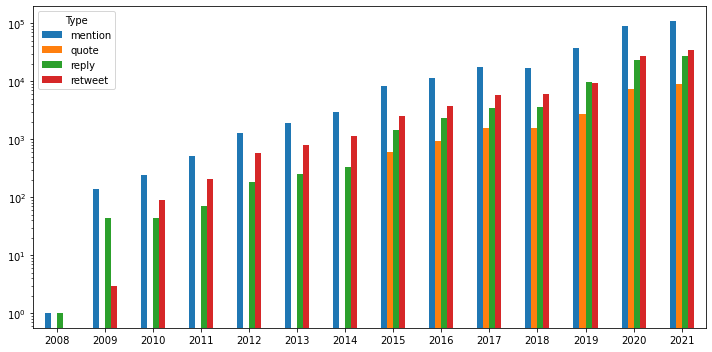

In [494]:
interaction_count = el_df.groupby(pd.Grouper(key='Timestamp',freq='Y'))['Type'].value_counts().unstack(1)
interaction_count.index = [i.year for i in interaction_count.index]

f,ax = plt.subplots(figsize=(10,5))
interaction_count.plot.bar(ax=ax)
ax.set_yscale('log')
ax.set_xticklabels(ax.get_xticklabels(),rotation=0);

f.tight_layout()
f.savefig('interaction_types.png',facecolor='w',bbox_inches='tight')

Plot the number of mentions by month.

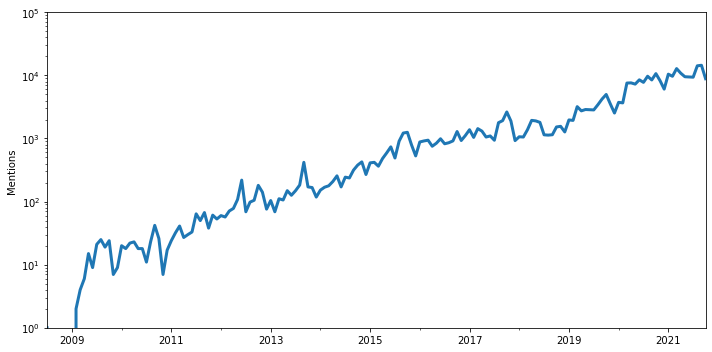

In [506]:
f,ax = plt.subplots(figsize=(10,5))
mention_el.groupby(pd.Grouper(key='Timestamp',freq='M')).agg({'Timestamp':'count'})['Timestamp'].plot(lw = 3,ax=ax)
# ax.set_ylim((0,16000))
ax.set_ylim((1e0,1e5))
ax.set_ylabel('Mentions')
ax.set_xlabel('')
ax.set_yscale('log')

f.tight_layout()
f.savefig('monthly_mentions.png',facecolor='w',bbox_inches='tight')

## Mentions network over time

In [243]:
# Subset to the mention type
mention_el = el_df[el_df['Type']=='mention']

# Groupby a quarterly frequency and aggregate the From-To dyads
mention_agg = mention_el.groupby([pd.Grouper(key='Timestamp',freq='M'),'From','To']).agg({'Type':'count'}).reset_index()

# Rename to weight
mention_agg = mention_agg.rename(columns={'Type':'weight'})

# Inspect
mention_agg.head()

,Timestamp,From,To,weight
0,2008-07-31 00:00:00+00:00,mdpiper,barackobama,1
1,2009-02-28 00:00:00+00:00,stevefenberg,jaredpolis,2
2,2009-03-31 00:00:00+00:00,mapragency,doylealbee,4
3,2009-04-30 00:00:00+00:00,boulderadvocacy,espinozaa,2
4,2009-04-30 00:00:00+00:00,helzapoppen,fishnette,2


Text(0, 0.5, 'Fraction of users present')

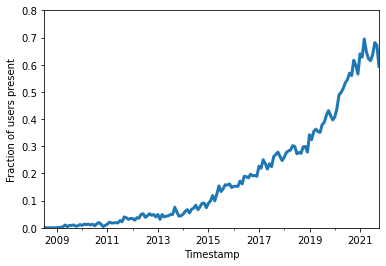

In [268]:
user_fraction_s = mention_el.groupby(pd.Grouper(key='Timestamp',freq='M')).agg({'From':'nunique'})['From']
user_fraction_s = user_fraction_s/len(el_df['From'].unique())

ax = user_fraction_s.plot(lw=3)
ax.set_ylim((0,.8))
ax.set_ylabel('Fraction of users present')

Text(0, 0.5, 'Fraction of users present')

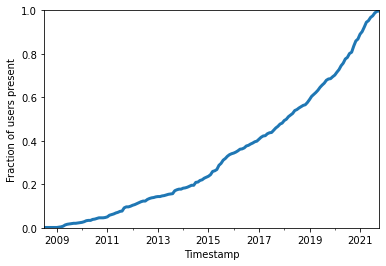

In [288]:
names = mention_el.groupby(pd.Grouper(key='Timestamp',freq='M')).agg({'From':'unique'})['From'].fillna('')

# This is an epic and atrocious hack to generate a cumulative sum of lists
cuml_names = names.apply(lambda x:','.join(x)+',').cumsum().apply(lambda x:set([i for i in x.split(',') if len(i) > 0]))
cuml_names_frac = cuml_names.apply(len)/len(el_df['From'].unique())

ax = cuml_names_frac.plot(lw=3)
ax.set_ylim((0,1))
ax.set_ylabel('Fraction of users present')

What is the distribution of mention weights?

Text(0, 0.5, 'CCDF')

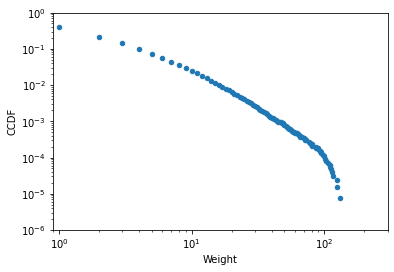

In [244]:
# Count and sort the monthly
s = mention_agg['weight'].value_counts().sort_index(ascending=True)
ccdf = 1 - s.cumsum()/s.sum()
ax = ccdf.reset_index().plot.scatter(x='index',y='weight')
ax.set_xlim((.9,3e2))
ax.set_ylim((1e-6,1e0))
ax.set_xscale('log')
ax.set_yscale('log')
ax.set_xlabel('Weight')
ax.set_ylabel('CCDF')

In [292]:
mention_agg.sort_values('weight',ascending=False).head(10)

,Timestamp,From,To,weight
113448,2021-07-31 00:00:00+00:00,rockymntnpols,dailycamera,153
69689,2020-08-31 00:00:00+00:00,kamalaharris,joebiden,132
63019,2020-06-30 00:00:00+00:00,jpstrategiesco,portiacolorado,125
23925,2018-04-30 00:00:00+00:00,boulderopera,downtownboulder,124
81144,2020-11-30 00:00:00+00:00,kamalaharris,joebiden,117
18183,2017-08-31 00:00:00+00:00,richardvalenty,planboulder,115
118316,2021-08-31 00:00:00+00:00,rockymntnpols,dailycamera,113
77330,2020-10-31 00:00:00+00:00,kamalaharris,joebiden,111
8266,2016-02-29 00:00:00+00:00,aliciawallace,denverpost,110
88098,2021-01-31 00:00:00+00:00,markyv,ericmbudd,106


## Snapshot networks

In [246]:
# Empty container to fill
snapshot_g = {}

# For each unique monthly timestamp
for _date in mention_agg['Timestamp'].dt.date.unique():
    
    # Get the mention dyads that happened in that month
    _el = mention_agg[mention_agg['Timestamp'].dt.date==_date]
    
    # Create a graph and index by date
    snapshot_g[str(_date)] = nx.from_pandas_edgelist(
        df = _el,
        source = 'From',
        target = 'To',
        edge_attr = ['weight'],
        create_using = nx.DiGraph
    )

In [388]:
snapshot_stats = {}
for _date, _g in snapshot_g.items():
    snapshot_stats[_date] = {}
    snapshot_stats[_date]['Nodes'] = _g.number_of_nodes()
    snapshot_stats[_date]['Edges'] = _g.number_of_edges()
    snapshot_stats[_date]['Density'] = nx.density(_g)
    snapshot_stats[_date]['Clustering'] = nx.average_clustering(_g)
    snapshot_stats[_date]['Avg In-Degree'] = np.mean([d for n,d in _g.in_degree()])
    snapshot_stats[_date]['Avg Out-Degree'] = np.mean([d for n,d in _g.out_degree()])
        
    lcc = nx.subgraph(_g.to_undirected(),max(nx.components.connected_components(_g.to_undirected()),key=len))
    
    snapshot_stats[_date]['Diameter'] = nx.diameter(lcc)
    snapshot_stats[_date]['Avg. Shortest Path'] = nx.average_shortest_path_length(lcc)
    snapshot_stats[_date]['LCC fraction'] = len(lcc)/len(_g)
    
snapshot_stats_df = pd.DataFrame(snapshot_stats).T
snapshot_stats_df.index = pd.to_datetime(snapshot_stats_df.index)
snapshot_stats_df.head()

,Nodes,Edges,Density,Clustering,Avg In-Degree,Avg Out-Degree,LCC fraction,Diameter,Avg. Shortest Path
2008-07-31,2.0,1.0,0.500000,0.0,0.500000,0.500000,1.000000,1.0,1.000000
2009-02-28,2.0,1.0,0.500000,0.0,0.500000,0.500000,1.000000,1.0,1.000000
2009-03-31,2.0,1.0,0.500000,0.0,0.500000,0.500000,1.000000,1.0,1.000000
2009-04-30,7.0,4.0,0.095238,0.0,0.571429,0.571429,0.428571,2.0,1.333333
2009-05-31,13.0,7.0,0.044872,0.0,0.538462,0.538462,0.230769,2.0,1.333333


In [530]:
snapshot_stats_df.tail()

,Nodes,Edges,Density,Clustering,Avg In-Degree,Avg Out-Degree,LCC fraction,Diameter,Avg. Shortest Path
2021-06-30,489.0,3768.0,0.015790,0.191854,7.705521,7.705521,1.000000,7.0,2.823578
2021-07-31,494.0,3850.0,0.015808,0.214555,7.793522,7.793522,1.000000,6.0,2.781984
2021-08-31,526.0,5081.0,0.018399,0.235245,9.659696,9.659696,1.000000,6.0,2.671975
2021-09-30,511.0,5471.0,0.020993,0.250472,10.706458,10.706458,0.996086,6.0,2.615999
2021-10-31,468.0,3524.0,0.016124,0.230220,7.529915,7.529915,0.991453,6.0,2.817960


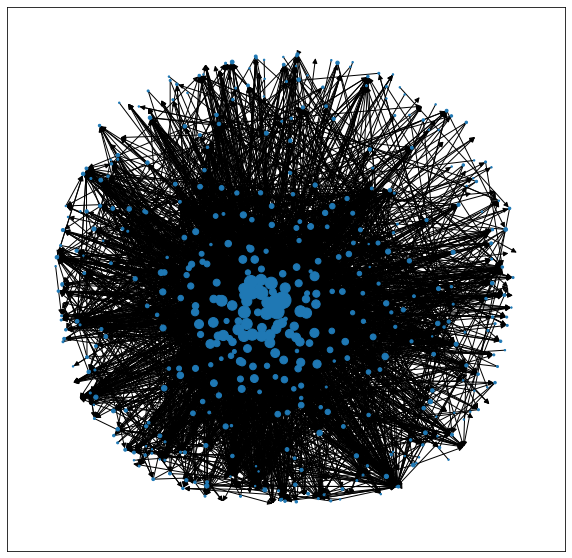

In [248]:
_g = snapshot_g['2021-09-30'].copy()
_g.remove_edges_from(nx.selfloop_edges(_g))
lcc = nx.subgraph(_g,max(nx.components.connected_components(_g.to_undirected()),key=len))

pos = nx.layout.spring_layout(lcc,k=.8)

f,ax = plt.subplots(figsize=(10,10))
nx.draw_networkx(
    G = lcc,
    pos = pos,
    with_labels = False,
    node_size = [d * 2 for n,d in lcc.out_degree()],
    ax = ax
)

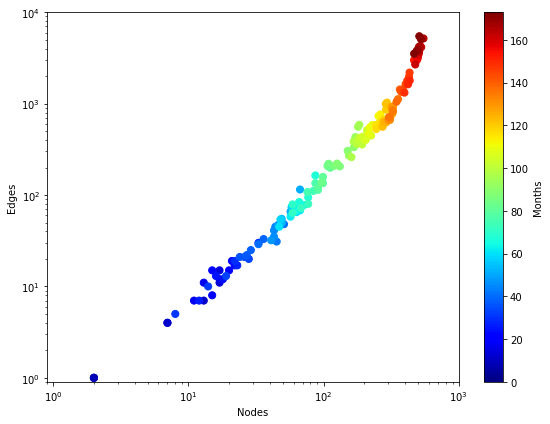

In [255]:
delta = (snapshot_stats_df.index - pd.Timestamp('2008-07-31'))/pd.Timedelta('28d')

f,ax = plt.subplots(figsize=(8,6))

s = ax.scatter(
    x = snapshot_stats_df['Nodes'],
    y = snapshot_stats_df['Edges'],
    s = 50,
    c = delta,
    cmap='jet'
)

ax.set_xscale('log')
ax.set_yscale('log')
ax.set_xlim((.9,1e3))
ax.set_ylim((.9,1e4))
ax.set_xlabel('Nodes')
ax.set_ylabel('Edges')

cbar = plt.colorbar(s,label='Months')

f.tight_layout()

These are similar to Figure 3 in Kossinets & Watts (2006).

Text(0, 0.5, 'Density')

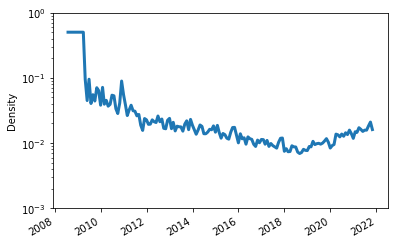

In [330]:
ax = snapshot_stats_df['Density'].plot(lw=3)
ax.set_yscale('log')
ax.set_ylim((1e-3,1e0))
ax.set_ylabel('Density')

Text(0, 0.5, 'Clustering')

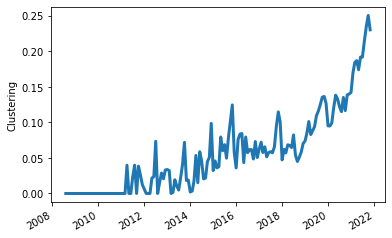

In [327]:
ax = snapshot_stats_df['Clustering'].plot(lw=3)
ax.set_ylabel('Clustering')

(-0.01, 12.0)

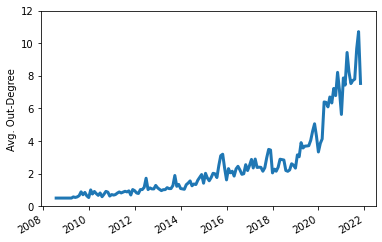

In [326]:
ax = snapshot_stats_df['Avg Out-Degree'].plot(lw=3)
ax.set_ylabel('Avg. Out-Degree')
ax.set_ylim((-.01,12))

Text(0, 0.5, 'LCC fraction')

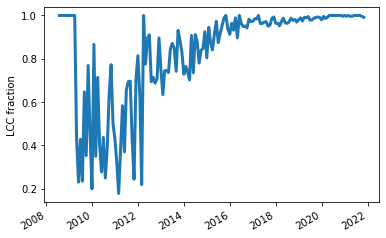

In [329]:
ax = snapshot_stats_df['LCC fraction'].plot(lw=3)
ax.set_ylabel('LCC fraction')

(0.0, 14.0)

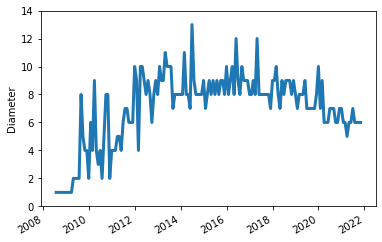

In [390]:
ax = snapshot_stats_df['Diameter'].plot(lw=3)
ax.set_ylabel('Diameter')
ax.set_ylim((0,14))

(0.0, 6.0)

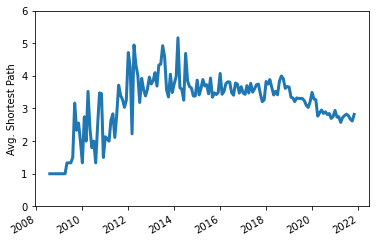

In [392]:
ax = snapshot_stats_df['Avg. Shortest Path'].plot(lw=3)
ax.set_ylabel('Avg. Shortest Path')
ax.set_ylim((0,6))

Make a triadic census of the network by month.

In [535]:
nx.triadic_census(snapshot_g['2010-01-31'])

{'003': 281,
 '012': 153,
 '102': 0,
 '021D': 14,
 '021U': 7,
 '021C': 0,
 '111D': 0,
 '111U': 0,
 '030T': 0,
 '030C': 0,
 '201': 0,
 '120D': 0,
 '120U': 0,
 '120C': 0,
 '210': 0,
 '300': 0}

In [536]:
nx.triadic_census(snapshot_g['2021-01-31'])

{'003': 22536714,
 '012': 1559272,
 '102': 180272,
 '021D': 22402,
 '021U': 54352,
 '021C': 15637,
 '111D': 7433,
 '111U': 9198,
 '030T': 4070,
 '030C': 18,
 '201': 1634,
 '120D': 676,
 '120U': 1427,
 '120C': 167,
 '210': 391,
 '300': 113}

In [252]:
snapshot_triadic_census_d = {}

for _date, _g in snapshot_g.items():
    if len(_g) > 2:
        _census = {k:v/(len(_g) * (len(_g) - 1) * (len(_g) - 2)) for k,v in nx.triadic_census(_g).items()}
        snapshot_triadic_census_d[_date] = _census

Visualize as a heatmap.

<AxesSubplot:>

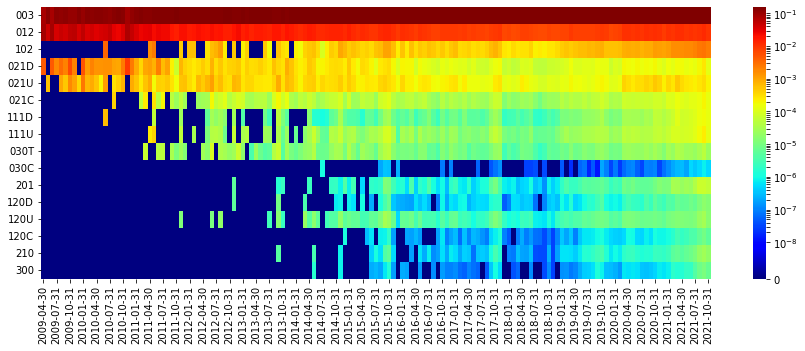

In [253]:
snapshot_triadic_census_df = pd.DataFrame(snapshot_triadic_census_d)

f,ax = plt.subplots(figsize=(15,5))
sb.heatmap(
    data = snapshot_triadic_census_df,
    norm = mcolors.SymLogNorm(linthresh=1e-8),
    cmap = 'jet',
    ax = ax)

What fraction of the nodes and edges present in the current month were present in the previous month?

In [516]:
curr = snapshot_g['2021-09-30']
prev = snapshot_g['2021-08-31']

nodes_added = set(curr.nodes()) - set(prev.nodes())
nodes_lost = set(prev.nodes()) - set(curr.nodes())
nodes_remain = set(prev.nodes()) & set(curr.nodes())

edges_added = set(curr.edges()) - set(prev.edges())
edges_lost = set(prev.edges()) - set(curr.edges())
edges_remain = set(prev.edges()) & set(curr.edges())

both_g = nx.DiGraph()
union_edges = set(curr.edges()) | set(prev.edges())
both_g.add_edges_from(list(union_edges))

both_g.remove_edges_from(nx.selfloop_edges(_g))
lcc = nx.subgraph(both_g,max(nx.components.connected_components(both_g.to_undirected()),key=len))

Text(0.5, 1.0, 'Nodes and edges remaining')

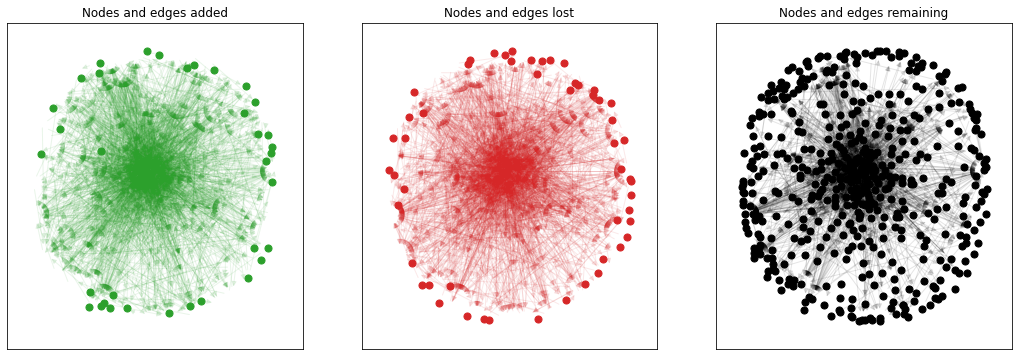

In [576]:
pos = nx.layout.spring_layout(lcc,k=.8)

f,axs = plt.subplots(1,3,figsize=(18,6))

# Draw nodes
nx.draw_networkx_nodes(
    G = both_g,
    pos = pos,
    nodelist = [n for n in nodes_added if n in lcc.nodes()],
    node_color = 'tab:green',
    node_size = 50,
    ax=axs[0]
)

nx.draw_networkx_nodes(
    G = both_g,
    pos = pos,
    nodelist = [n for n in nodes_lost if n in lcc.nodes()],
    node_color = 'tab:red',
    node_size = 50,
    ax=axs[1]
)

nx.draw_networkx_nodes(
    G = both_g,
    pos = pos,
    nodelist = [n for n in nodes_remain if n in lcc.nodes()],
    node_color = 'k',
    node_size = 50,
    ax=axs[2]
)

# Draw edges
nx.draw_networkx_edges(
    G = both_g,
    pos = pos,
    edgelist = [n for n in edges_added if n in lcc.edges()],
    edge_color = 'tab:green',
    alpha = .1,
    ax=axs[0]
)

nx.draw_networkx_edges(
    G = both_g,
    pos = pos,
    edgelist = [n for n in edges_lost if n in lcc.edges()],
    edge_color = 'tab:red',
    alpha = .1,
    ax=axs[1]
)

nx.draw_networkx_edges(
    G = both_g,
    pos = pos,
    edgelist = [n for n in edges_remain if n in lcc.edges()],
    edge_color = 'k',
    alpha = .1,
    ax=axs[2]
)

axs[0].set_title('Nodes and edges added')
axs[1].set_title('Nodes and edges lost')
axs[2].set_title('Nodes and edges remaining')

Text(0, 0.5, 'Jaccard score')

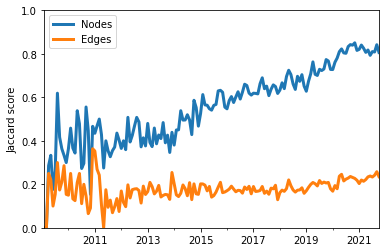

In [380]:
snapshot_jaccard_scores = {}
for i,(d,g) in enumerate(snapshot_g.items()):
    if i > 0:
        snapshot_jaccard_scores[d] = {}
        
        last = list(snapshot_g.keys())[i-1]
        curr = list(snapshot_g.keys())[i]
        
        # Nodes
        last_nodes = set(snapshot_g[last].nodes())
        curr_nodes = set(snapshot_g[curr].nodes())
        snapshot_jaccard_scores[d]['Nodes'] = len(last_nodes & curr_nodes)/len(last_nodes | curr_nodes)
        snapshot_jaccard_scores[d]['Nodes Created'] = len(curr_nodes - last_nodes)#/len(last_nodes)
        snapshot_jaccard_scores[d]['Nodes Lost'] = len(last_nodes - curr_nodes)#/len(curr_nodes)
        
        # Edges
        last_edges = set(snapshot_g[last].edges())
        curr_edges = set(snapshot_g[curr].edges())
        snapshot_jaccard_scores[d]['Edges'] = len(last_edges & curr_edges)/len(last_edges | curr_edges)
        snapshot_jaccard_scores[d]['Edges Created'] = len(curr_edges - last_edges)#/len(last_edges)
        snapshot_jaccard_scores[d]['Edges Lost'] = len(last_edges - curr_edges)#/len(curr_edges)
        
snapshot_jaccard_scores_df = pd.DataFrame(snapshot_jaccard_scores).T
snapshot_jaccard_scores_df.index = pd.to_datetime(snapshot_jaccard_scores_df.index)

ax = snapshot_jaccard_scores_df[['Nodes','Edges']].plot(lw=3)
ax.set_ylim((0,1))
ax.set_ylabel('Jaccard score')

<AxesSubplot:>

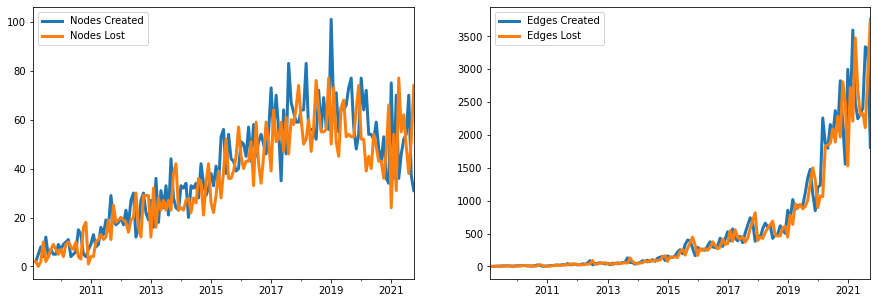

In [381]:
f,axs = plt.subplots(1,2,figsize=(15,5))
snapshot_jaccard_scores_df[['Nodes Created','Nodes Lost']].plot(lw=3,ax=axs[0])
snapshot_jaccard_scores_df[['Edges Created','Edges Lost']].plot(lw=3,ax=axs[1])

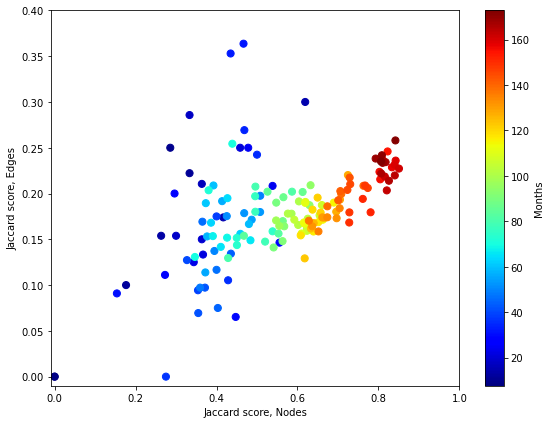

In [382]:
f,ax = plt.subplots(figsize=(8,6))

s = ax.scatter(
    x = snapshot_jaccard_scores_df['Nodes'],
    y = snapshot_jaccard_scores_df['Edges'],
    s = 50,
    c = delta[1:],
    cmap='jet'
)

ax.set_xlim((-.01,1))
ax.set_ylim((-.01,.4))
ax.set_xlabel('Jaccard score, Nodes')
ax.set_ylabel('Jaccard score, Edges')

cbar = plt.colorbar(s,label='Months')

f.tight_layout()

Text(0, 0.5, 'Edges Lost')

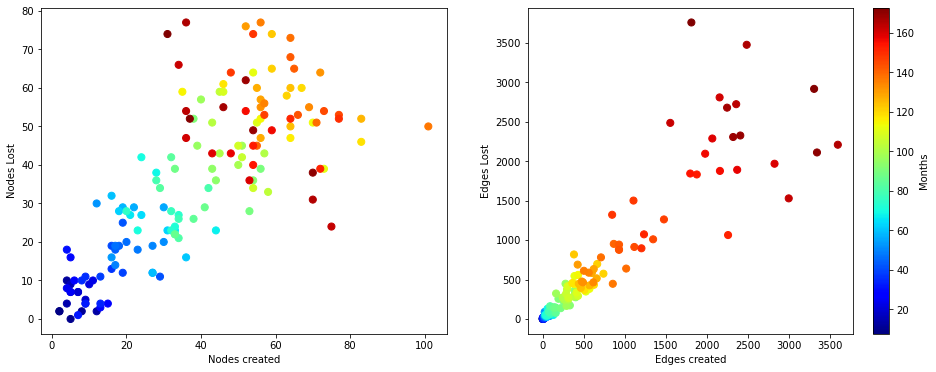

In [385]:
f,axs = plt.subplots(1,2,figsize=(16,6))

s0 = axs[0].scatter(
    x = snapshot_jaccard_scores_df['Nodes Created'],
    y = snapshot_jaccard_scores_df['Nodes Lost'],
    s = 50,
    c = delta[1:],
    cmap='jet'
)

s1 = axs[1].scatter(
    x = snapshot_jaccard_scores_df['Edges Created'],
    y = snapshot_jaccard_scores_df['Edges Lost'],
    s = 50,
    c = delta[1:],
    cmap='jet'
)

cbar = plt.colorbar(s1,label='Months')

axs[0].set_xlabel('Nodes created')
axs[0].set_ylabel('Nodes Lost')

axs[1].set_xlabel('Edges created')
axs[1].set_ylabel('Edges Lost')

# f.tight_layout()

Probabilities of tie creation based on distance and mutuals in previous network.

In [441]:
def mutuals(g,node1,node2):
    try:
        node1_neighbors = set(g.succ[node1]) | set(g.pred[node1])
    except:
        node1_neighbors = set()
        
    try:
        node2_neighbors = set(g.succ[node2]) | set(g.pred[node2])
    except:
        node2_neighbors = set()
        
    return list(node1_neighbors & node2_neighbors)

In [449]:
snapshot_distance = {}
snapshot_mutuals = {}
for i,(d,g) in enumerate(snapshot_g.items()):
    if i > 0:
        snapshot_distance[d] = {}
        snapshot_mutuals[d] = {}
        
        last = list(snapshot_g.values())[i-1]
        curr = list(snapshot_g.values())[i]
        
        spl = dict(nx.all_pairs_shortest_path_length(last))
        
        spl_df = pd.DataFrame(spl).stack().reset_index()
        spl_df.columns = ['Source','Target','Distance']
        spl_df['Exists'] = spl_df.apply(lambda x:int(curr.has_edge(x['Source'],x['Target'])),axis=1)
        spl_df['Mutuals'] = spl_df.apply(lambda x:len(mutuals(_curr,x['Source'],x['Target'])),axis=1)
        
        snapshot_distance[d] = spl_df[spl_df['Distance']>0].groupby('Distance').agg({'Exists':'mean'})['Exists']
        snapshot_mutuals[d] = spl_df[spl_df['Distance']>0].groupby('Mutuals').agg({'Exists':'mean'})['Exists']

This is similar to Figure 1A in Kossinets & Watts (2006).

(0.0, 0.05)

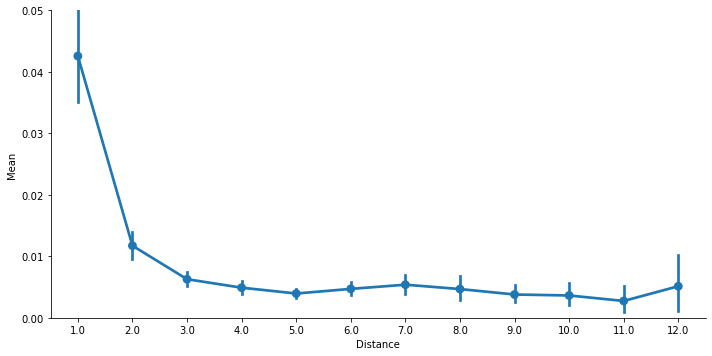

In [539]:
snapshot_distance_df = pd.DataFrame(snapshot_distance).T.stack().reset_index()
snapshot_distance_df.columns = ['Date','Distance','Mean']

_df = snapshot_distance_df[snapshot_distance_df['Distance'] < 13]
g = sb.catplot(
    x='Distance',
    y='Mean',
    data=_df,
    kind='point',
    aspect=2
)
ax = g.axes[0,0]
ax.set_ylim((0,.05))
# ax.set_yscale('symlog',linthresh=1e-2)

These are similar to Figure 1B in Kossinets & Watts (2006).

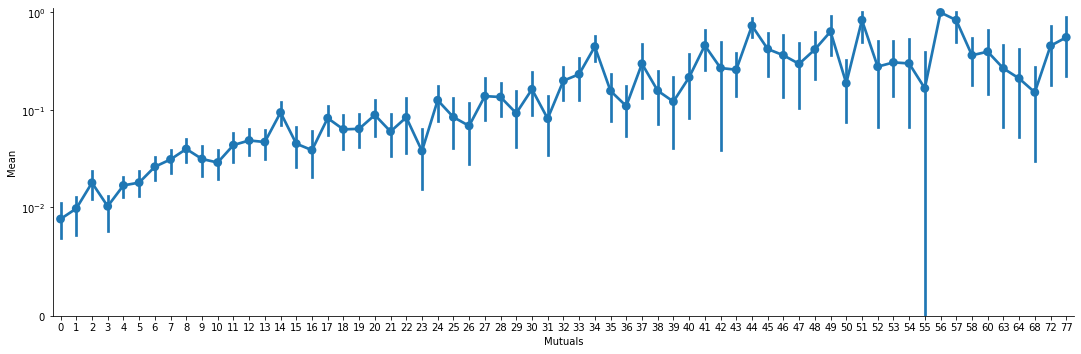

In [551]:
snapshot_mutuals_df = pd.DataFrame(snapshot_mutuals).T.stack().reset_index()
snapshot_mutuals_df.columns = ['Date','Mutuals','Mean']
snapshot_mutuals_df['Mutuals binned'] = pd.cut(snapshot_mutuals_df['Mutuals'],bins=10)

g = sb.catplot(x='Mutuals',y='Mean',data=snapshot_mutuals_df,kind='point',aspect=3)
ax = g.axes[0,0]
ax.set_ylim((0,1.1))
ax.set_yscale('symlog',linthresh=1e-2)

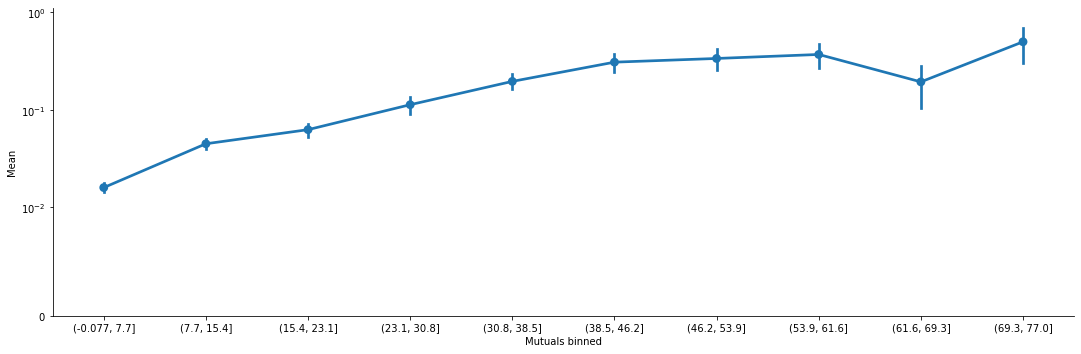

In [550]:
g = sb.catplot(x='Mutuals binned',y='Mean',data=snapshot_mutuals_df,kind='point',aspect=3)
ax = g.axes[0,0]
ax.set_ylim((0,1.1))
ax.set_yscale('symlog',linthresh=1e-2)

These are similar to Figure 4 in Kossinets & Watts (2006).

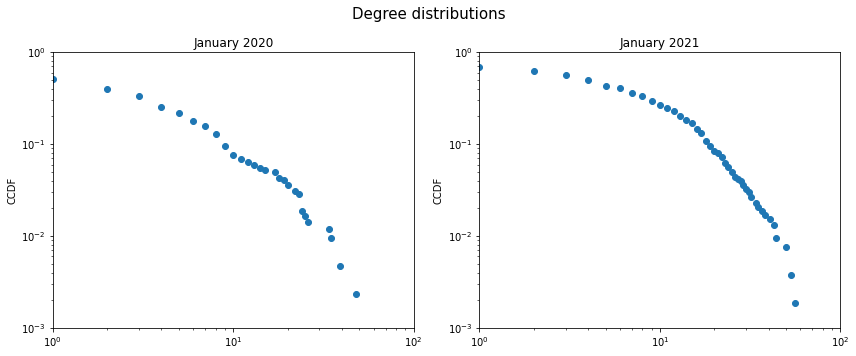

In [638]:
f,axs = plt.subplots(1,2,figsize=(12,5),
                     subplot_kw={
                         'xscale':'log',
                         'yscale':'log',
                         'xlim':(1e0,1e2),
                         'ylim':(1e-3,1e0),
                     })

dd_20210131 = pd.Series(dict(snapshot_g['2021-01-31'].out_degree())).value_counts().sort_index().reset_index()
dd_20210131.columns = ['Degree','Count']
dd_20210131['CCDF'] = 1 - dd_20210131['Count'].cumsum()/dd_20210131['Count'].sum()

dd_20200131 = pd.Series(dict(snapshot_g['2020-01-31'].out_degree())).value_counts().sort_index().reset_index()
dd_20200131.columns = ['Degree','Count']
dd_20200131['CCDF'] = 1 - dd_20200131['Count'].cumsum()/dd_20200131['Count'].sum()

axs[0].scatter(
    x = dd_20200131['Degree'],
    y = dd_20200131['CCDF']
)

axs[1].scatter(
    x = dd_20210131['Degree'],
    y = dd_20210131['CCDF']
)

axs[0].set_title('January 2020')
axs[1].set_title('January 2021')

axs[0].set_ylabel('CCDF')
axs[1].set_ylabel('CCDF')

f.suptitle('Degree distributions',fontsize=15)
f.tight_layout()

In [639]:
dh_d = {}
for _date, _g in snapshot_g.items():
    _s = pd.Series(nx.degree_histogram(_g))
    dh_d[_date] = _s/_s.sum()
    
dh_df = pd.DataFrame(dh_d).T.fillna(0)

dh_df.tail()

,0,1,2,3,4,5,6,7,8,9,...,243,244,245,246,247,248,249,250,251,252
2021-06-30,0.0,0.112474,0.085890,0.077710,0.049080,0.063395,0.044990,0.036810,0.047035,0.047035,...,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000
2021-07-31,0.0,0.113360,0.105263,0.056680,0.062753,0.060729,0.042510,0.056680,0.032389,0.036437,...,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000
2021-08-31,0.0,0.121673,0.095057,0.062738,0.055133,0.043726,0.047529,0.036122,0.022814,0.030418,...,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.001901
2021-09-30,0.0,0.117417,0.076321,0.048924,0.035225,0.046967,0.052838,0.037182,0.021526,0.045010,...,0.0,0.0,0.001957,0.0,0.0,0.0,0.0,0.0,0.0,0.000000
2021-10-31,0.0,0.141026,0.096154,0.064103,0.061966,0.055556,0.064103,0.036325,0.040598,0.044872,...,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000


Figure 4C from Kossinets & Watts (2006).

Text(0, 0.5, 'Kolmogorov-Smirnov statistic')

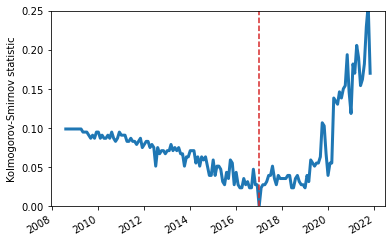

In [642]:
ks_s = dh_df.apply(lambda x:stats.ks_2samp(x,dh_df.loc['2016-12-31'])[0],axis=1)
ks_s.index = pd.to_datetime(ks_s.index)

ax = ks_s.plot(lw=3)
ax.set_ylim((0,.25))
ax.axvline(pd.Timestamp('2016-12-31'),ls='--',c='tab:red')
ax.set_ylabel('Kolmogorov-Smirnov statistic')
# ax.set_xticklabels(ax.get_xticklabels(),rotation=0,rotation_mode='anchor');

Figure 4D from Kossinets & Watts (2006).

Text(0, 0.5, 'Dissimilarity coefficient')

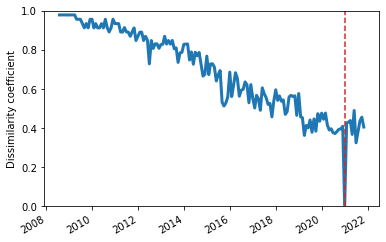

In [641]:
dissim_s = dh_df.apply(lambda x:1-stats.spearmanr(x,dh_df.loc['2020-12-31'])[0]**2,axis=1)
dissim_s.index = pd.to_datetime(dissim_s.index)

ax = dissim_s.plot(lw=3)
ax.set_ylim((0,1))
ax.axvline(pd.Timestamp('2020-12-31'),ls='--',c='tab:red')
ax.set_ylabel('Dissimilarity coefficient')
# ax.set_xticklabels(ax.get_xticklabels(),rotation=0,rotation_mode='anchor');

## Cumulative networks

In [332]:
cuml_g = {}
for _date in mention_agg['Timestamp'].dt.date.unique():
    _el = mention_agg[mention_agg['Timestamp'].dt.date<=_date]
    _el2 = _el.groupby(['From','To']).agg({'weight':'sum'}).reset_index()
    cuml_g[str(_date)] = nx.from_pandas_edgelist(
        df = _el2,
        source = 'From',
        target = 'To',
        edge_attr = ['weight'],
        create_using = nx.DiGraph
    )

In [333]:
cuml_stats = {}
for _date, _g in cuml_g.items():
    cuml_stats[_date] = {}
    cuml_stats[_date]['Nodes'] = _g.number_of_nodes()
    cuml_stats[_date]['Edges'] = _g.number_of_edges()
    cuml_stats[_date]['Density'] = nx.density(_g)
    cuml_stats[_date]['Clustering'] = n
    x.average_clustering(_g)
    cuml_stats[_date]['Avg In-Degree'] = np.mean([d for n,d in _g.in_degree()])
    cuml_stats[_date]['Avg Out-Degree'] = np.mean([d for n,d in _g.out_degree()])
    lcc_size = len(max(nx.components.connected_components(_g.to_undirected()),key=len))
    cuml_stats[_date]['LCC fraction'] = lcc_size/len(_g)
    
cuml_stats_df = pd.DataFrame(cuml_stats).T
cuml_stats_df.index = pd.to_datetime(cuml_stats_df.index)
cuml_stats_df.head()

,Nodes,Edges,Density,Clustering,Avg In-Degree,Avg Out-Degree,LCC fraction
2008-07-31,2.0,1.0,0.500000,0.0,0.500000,0.500000,1.000000
2009-02-28,4.0,2.0,0.166667,0.0,0.500000,0.500000,0.500000
2009-03-31,6.0,3.0,0.100000,0.0,0.500000,0.500000,0.333333
2009-04-30,11.0,6.0,0.054545,0.0,0.545455,0.545455,0.272727
2009-05-31,17.0,10.0,0.036765,0.0,0.588235,0.588235,0.176471


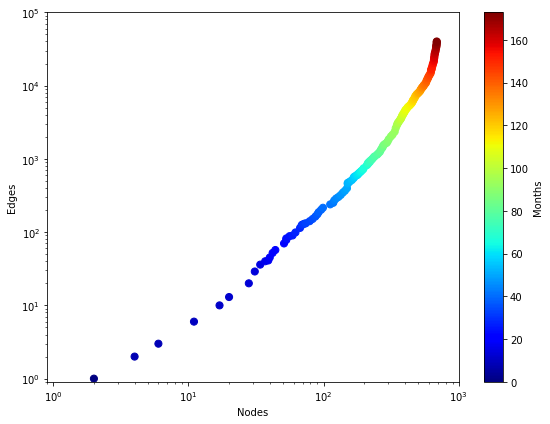

In [337]:
f,ax = plt.subplots(figsize=(8,6))

s = ax.scatter(
    x = cuml_stats_df['Nodes'],
    y = cuml_stats_df['Edges'],
    s = 50,
    c = delta,
    cmap='jet'
)

ax.set_xscale('log')
ax.set_yscale('log')
ax.set_xlim((.9,1e3))
ax.set_ylim((.9,1e5))
ax.set_xlabel('Nodes')
ax.set_ylabel('Edges')

cbar = plt.colorbar(s,label='Months')

f.tight_layout()

Text(0, 0.5, 'Density')

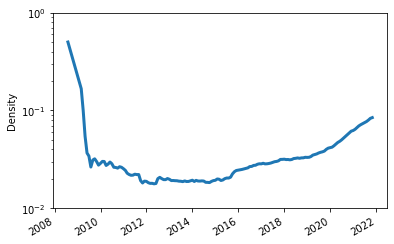

In [349]:
ax = cuml_stats_df['Density'].plot(lw=3)
ax.set_yscale('log')
ax.set_ylim((1e-2,1e0))
ax.set_ylabel('Density')

Text(0, 0.5, 'Avg. Clustering')

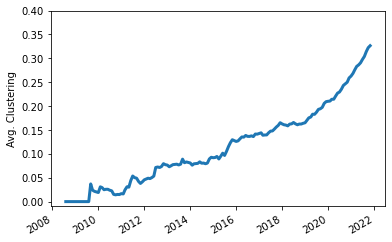

In [350]:
ax = cuml_stats_df['Clustering'].plot(lw=3)
ax.set_ylim((-.01,.4))
ax.set_ylabel('Avg. Clustering')

(-0.01, 60.0)

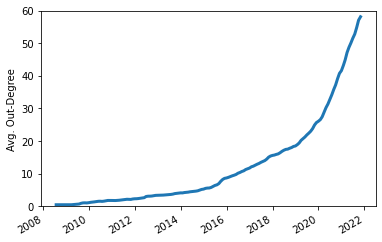

In [347]:
ax = cuml_stats_df['Avg Out-Degree'].plot(lw=3)
ax.set_ylabel('Avg. Out-Degree')
ax.set_ylim((-.01,60))

Text(0, 0.5, 'LCC fraction')

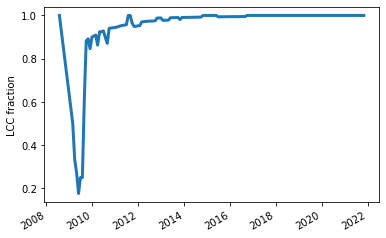

In [348]:
ax = cuml_stats_df['LCC fraction'].plot(lw=3)
ax.set_ylabel('LCC fraction')

Triadic censuses.

In [351]:
cuml_triadic_census_d = {}

for _date, _g in cuml_g.items():
    if len(_g) > 2:
        _census = {k:v/(len(_g) * (len(_g) - 1) * (len(_g) - 2)) for k,v in nx.triadic_census(_g).items()}
        cuml_triadic_census_d[_date] = _census

<AxesSubplot:>

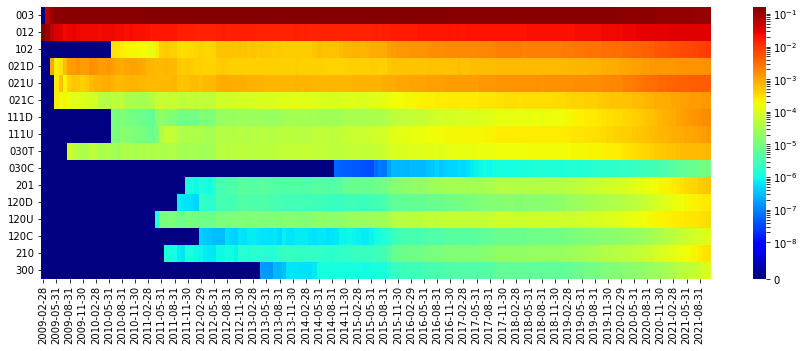

In [352]:
cuml_triadic_census_df = pd.DataFrame(cuml_triadic_census_d)

f,ax = plt.subplots(figsize=(15,5))
sb.heatmap(
    data = cuml_triadic_census_df,
    norm = mcolors.SymLogNorm(linthresh=1e-8),
    cmap = 'jet',
    ax = ax)

Text(0, 0.5, 'Jaccard score')

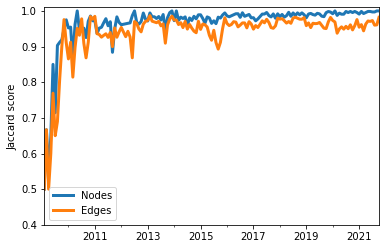

In [365]:
cuml_jaccard_scores = {}
for i,(d,g) in enumerate(cuml_g.items()):
    if i > 0:
        cuml_jaccard_scores[d] = {}
        
        last = list(cuml_g.keys())[i-1]
        curr = list(cuml_g.keys())[i]
        
        # Nodes
        last_nodes = set(cuml_g[last].nodes())
        curr_nodes = set(cuml_g[curr].nodes())
        cuml_jaccard_scores[d]['Nodes'] = len(last_nodes & curr_nodes)/len(last_nodes | curr_nodes)
        cuml_jaccard_scores[d]['Nodes Created'] = len(curr_nodes - last_nodes)
        cuml_jaccard_scores[d]['Nodes Lost'] = len(last_nodes - curr_nodes)
        
        # Edges
        last_edges = set(cuml_g[last].edges())
        curr_edges = set(cuml_g[curr].edges())
        cuml_jaccard_scores[d]['Edges'] = len(last_edges & curr_edges)/len(last_edges | curr_edges)
        cuml_jaccard_scores[d]['Edges Created'] = len(curr_edges - last_edges)
        cuml_jaccard_scores[d]['Edges Lost'] = len(last_edges - curr_edges)
        
cuml_jaccard_scores_df = pd.DataFrame(cuml_jaccard_scores).T
cuml_jaccard_scores_df.index = pd.to_datetime(cuml_jaccard_scores_df.index)

ax = cuml_jaccard_scores_df[['Nodes','Edges']].plot(lw=3)
ax.set_ylim((0.4,1.01))
ax.set_ylabel('Jaccard score')

<AxesSubplot:>

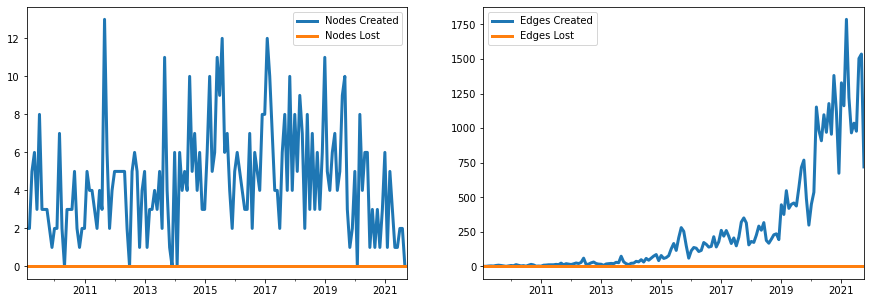

In [369]:
f,axs = plt.subplots(1,2,figsize=(15,5))
cuml_jaccard_scores_df[['Nodes Created','Nodes Lost']].plot(lw=3,ax=axs[0])
cuml_jaccard_scores_df[['Edges Created','Edges Lost']].plot(lw=3,ax=axs[1])

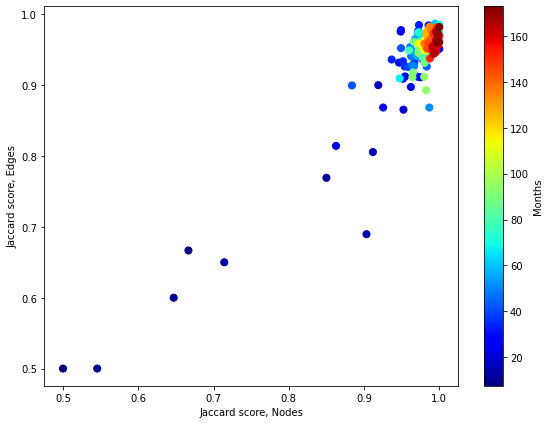

In [360]:
f,ax = plt.subplots(figsize=(8,6))

s = ax.scatter(
    x = cuml_jaccard_scores_df['Nodes'],
    y = cuml_jaccard_scores_df['Edges'],
    s = 50,
    c = delta[1:],
    cmap='jet'
)

# ax.set_xlim((-.01,1))
# ax.set_ylim((-.01,.4))
ax.set_xlabel('Jaccard score, Nodes')
ax.set_ylabel('Jaccard score, Edges')

cbar = plt.colorbar(s,label='Months')

f.tight_layout()

## Appendix

In [564]:
import pytz

In [109]:
with open('friend_list.json','r') as f:
    friend_list = json.load(f)
    
print(len(friend_list))

692


In [106]:
files = os.listdir('D:/Dropbox/Hacking/Boulder politics/Timelines')

In [575]:
# A container to store the edges
el = []

# Oldest tweet
latest_oldest_tweet = pd.to_datetime(datetime(2005,1,1, tzinfo=timezone.utc))

# Loop through each file
for file in files:
    
    # Load the JSON file
    with open('D:/Dropbox/Hacking/Boulder politics/Timelines/{0}'.format(file),'r') as f:
        tweets = json.load(f)

    # Keep track of the latest oldest tweet to know reliability of data
    oldest = pd.to_datetime(tweets[-1]['created_at'])
    
    if len(tweets) >= 100 and oldest > latest_oldest_tweet:
        latest_oldest_tweet = oldest
        
    # For each tweet in the user's timeline
    for i,t in enumerate(tweets):
    
        # Add the mentions
        for mention in t['entities']['user_mentions']:
            el.append(
                (t['user']['screen_name'].lower(),
                 mention['screen_name'].lower(),
                 t['created_at'],
                 'mention'
                )
            )

        # Add the replies
        if t['in_reply_to_screen_name'] is not None:
            el.append(
                (t['user']['screen_name'].lower(),
                 t['in_reply_to_screen_name'].lower(),
                 t['created_at'],
                 'reply'
                )
            )

        # Add the retweets
        if 'retweeted_status' in t:
            el.append(
                (t['user']['screen_name'].lower(),
                 t['retweeted_status']['user']['screen_name'].lower(),
                 t['created_at'],
                 'retweet'
                )
            )

        # Add the quote tweets
        if t['is_quote_status'] and 'retweeted_status' not in t and 'quoted_status' in t:
            el.append(
                (t['user']['screen_name'].lower(),
                 t['quoted_status']['user']['screen_name'].lower(),
                 t['created_at'],
                 'quote'
                )
            )
            
print(latest_oldest_tweet)

2021-10-10 16:15:45+00:00


In [195]:
# Convert to a DataFrame
el_df = pd.DataFrame(el)

# Label the columns
el_df.columns = ['From','To','Timestamp','Type']

# Subset to only the tweets among the friends
el_df = el_df[el_df['To'].isin(friend_list)]

# Ignore self-references
el_df = el_df[el_df['From'] != el_df['To']]

# Cast to a Timestamp
el_df['Timestamp'] = pd.to_datetime(el_df['Timestamp'])

# Write to disk
el_df.to_csv('interaction_edgelists.csv',index=False)

# Inspect
el_df.head()

,From,To,Timestamp,Type
7,1dapc,stephenking,2021-09-14 22:13:11+00:00,mention
8,1dapc,stephenking,2021-09-14 22:13:11+00:00,retweet
9,1dapc,danrather,2021-08-10 19:13:04+00:00,mention
10,1dapc,danrather,2021-08-10 19:13:04+00:00,retweet
11,1dapc,mitchellbyars,2021-08-10 19:12:03+00:00,mention


In [186]:
min_timestamps = el_df.groupby(['From','Type']).agg({'Timestamp':'min'})['Timestamp'].unstack(1)
min_timestamps.head()

Type,mention,quote,reply,retweet
From,,,,
1dapc,2016-11-25 05:16:38+00:00,2016-12-11 15:37:26+00:00,2016-11-18 15:56:19+00:00,2016-12-11 19:13:34+00:00
1markmcintyre,2019-01-26 01:42:41+00:00,2019-01-27 08:47:50+00:00,2019-01-26 01:42:41+00:00,2019-02-01 18:28:07+00:00
350colorado,2010-08-10 22:34:45+00:00,2017-10-31 05:00:24+00:00,2010-10-07 21:17:07+00:00,2010-10-02 23:14:12+00:00
400trix,2021-03-27 19:52:02+00:00,2021-04-20 02:27:21+00:00,2021-03-27 19:52:02+00:00,2021-04-13 20:11:56+00:00
505nomad,2021-05-30 03:18:36+00:00,NaT,2021-05-29 20:12:34+00:00,NaT
